In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import requests
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

## Processing and Pulling Data

In [87]:
dir_path = "/content/drive/MyDrive/2025-04-19_Existing Home Sales v. Mortgage Rate"
output_dir = os.path.join(dir_path, "outputs")

# Create the 'outputs' directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


In [4]:
API_KEY = 'd0946ae1532277ebd0b673c18f5283a3'
year10_treasury_yield = 'DGS10'

In [64]:
# Pulling data for 10 year inflation
def get_data(name, series_id, start_dates, end_dates):
  end_date = end_dates
  start_date = start_dates  # approx. 12 months

  params = {
      'series_id': series_id,
      'api_key': API_KEY,
      'file_type': 'json',
      'observation_start': start_date.strftime('%Y-%m-%d'),
      'observation_end': end_date.strftime('%Y-%m-%d')
  }

  url = 'https://api.stlouisfed.org/fred/series/observations'
  resp = requests.get(url, params=params)
  data = resp.json()['observations']

  df = pd.DataFrame(data)
  df.drop(columns  = ['realtime_start', 'realtime_end'], inplace = True)
  df.rename(columns = {'value': name}, inplace = True)

  # Converting to float for calc
  df[name] = pd.to_numeric(df[name], errors='coerce')
  df['pct_change'] = df[name].pct_change()*100
  df.dropna(inplace = True)
  df.reset_index(drop = True, inplace = True)

  return df

In [115]:
start = datetime(2010,1,1)
end = datetime(2025,5,1)

year10_yield_df = get_data("yield",year10_treasury_yield, start, end)

In [126]:
year10_yield_df['date'] = pd.to_datetime(year10_yield_df['date'])

In [127]:
year10_yield_monthly = year10_yield_df.resample('M', on = 'date').mean()

In [160]:
year10_yield_monthly

,date,yield,pct_change
0,2010-01,3.726667,-0.317837
1,2010-02,3.691053,-0.018744
2,2010-03,3.727391,0.275671
3,2010-04,3.846818,-0.171217
4,2010-05,3.420000,-0.519084
...,...,...,...
179,2024-12,4.391429,0.441122
180,2025-01,4.629048,0.005469
181,2025-02,4.451053,-0.397625
182,2025-03,4.280476,-0.003274


In [128]:
year10_yield_monthly = year10_yield_monthly.reset_index()

In [129]:
year10_yield_monthly['date'] = year10_yield_monthly['date'].dt.strftime('%Y-%m')

In [133]:
existing_sales = pd.read_excel(os.path.join("/content/drive/MyDrive/2025-04-19_Existing Home Sales v. Mortgage Rate/NAR Existing Home Sales_Running_v2.xlsx"))

## Cleaning Existing Sales and Creating Merged DF

In [134]:
existing_sales['Date_tr'] = pd.to_datetime(existing_sales['Date']).dt.strftime('%Y-%m')

existing_sales.sort_values(by = 'Date_tr', inplace = True)

In [135]:
existing_sales.drop(columns = ['Release Date','Date','Time'], inplace = True)

In [136]:
existing_sales.rename(columns = {'Date_tr': 'date'}, inplace = True)

In [137]:
# prompt: existing_sales['Actual'] has data as float followed byy M

existing_sales['Actual'] = existing_sales['Actual'].astype(str)
existing_sales['Actual'] = existing_sales['Actual'].str.replace('M', '')
existing_sales['Actual'] = pd.to_numeric(existing_sales['Actual'], errors='coerce')


In [ ]:
existing_sales

In [138]:
merged_df = pd.merge(existing_sales, year10_yield_monthly, on = 'date', how = 'right')

In [139]:
merged_df

,Actual,Forecast,Previous,date,yield,pct_change
0,5.45,5.95M,6.54M,2010-01,3.726667,-0.317837
1,5.05,5.50M,5.44M,2010-02,3.691053,-0.018744
2,5.02,5.00M,5.05M,2010-03,3.727391,0.275671
3,5.35,5.30M,5.01M,2010-04,3.846818,-0.171217
4,5.77,5.65M,5.36M,2010-05,3.420000,-0.519084
...,...,...,...,...,...,...
179,4.15,4.09M,3.96M,2024-12,4.391429,0.441122
180,4.24,4.19M,4.15M,2025-01,4.629048,0.005469
181,4.08,4.13M,4.29M,2025-02,4.451053,-0.397625
182,4.26,3.95M,4.09M,2025-03,4.280476,-0.003274


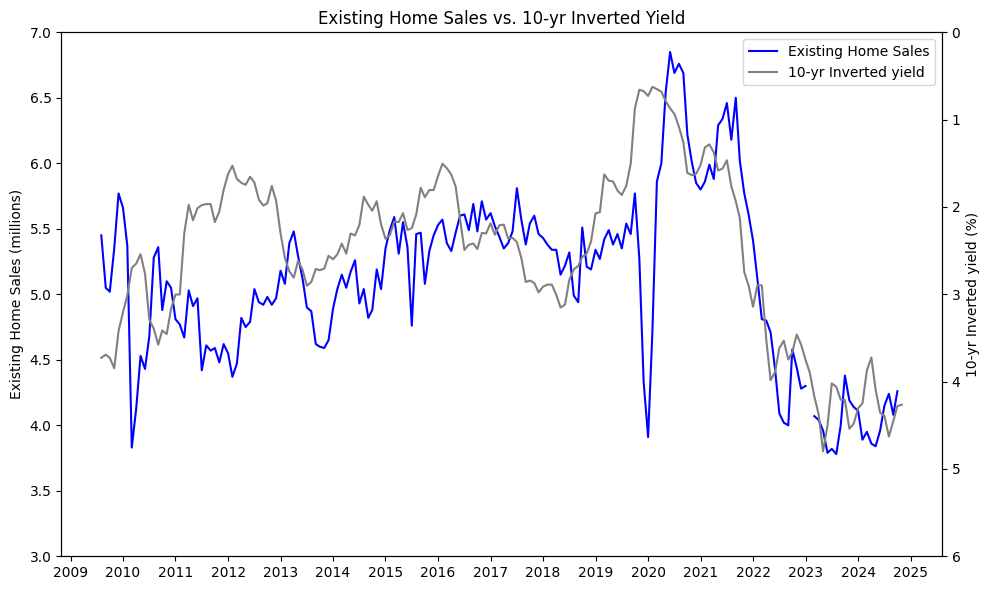

In [179]:


# ensure date is datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

fig, ax1 = plt.subplots(figsize=(10,6))

# y1 axis: Actual
ax1.plot(merged_df['date'], merged_df['Actual'], color='blue', label='Existing Home Sales')
ax1.set_ylabel('Existing Home Sales (millions)')
ax1.set_ylim(3, 7)

# y2 axis: yield, reversed
ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['yield'], color='gray', label='10‑yr Inverted yield')
ax2.set_ylabel('10‑yr Inverted yield (%)')
ax2.set_ylim(6, 0)   # reversed axis from 3 to 6

# x‑axis ticks every 6 months (optional)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=0)

# combine legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='best')

plt.title('Existing Home Sales vs. 10‑yr Inverted Yield')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'existing_sales_yield.png'))
plt.savefig(os.path.join(output_dir, 'existing_sales_yield.svg'))
plt.show()


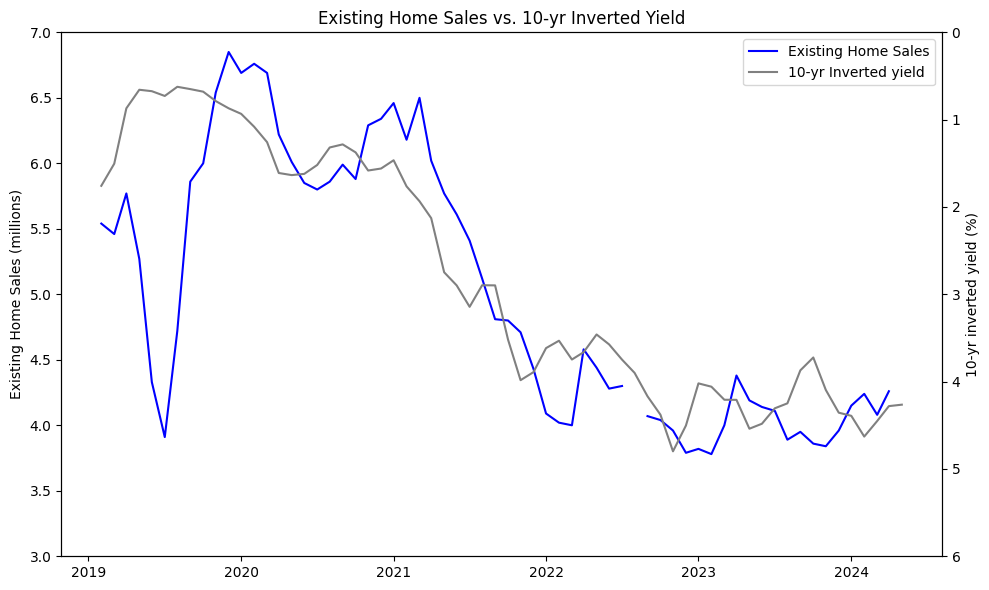

In [178]:
# ensure date is datetime
merged_df_2 = merged_df[merged_df['date'] >= '2020-01-01']

merged_df_2['date'] = pd.to_datetime(merged_df['date'])

fig, ax1 = plt.subplots(figsize=(10,6))

# y1 axis: Actual
ax1.plot(merged_df_2['date'], merged_df_2['Actual'], color='blue', label='Existing Home Sales')
ax1.set_ylabel('Existing Home Sales (millions)')
ax1.set_ylim(3, 7)

# y2 axis: yield, reversed
ax2 = ax1.twinx()
ax2.plot(merged_df_2['date'], merged_df_2['yield'], color='gray', label='10‑yr Inverted yield')
ax2.set_ylabel('10‑yr inverted yield (%)')
ax2.set_ylim(6, 0)   # reversed axis from 3 to 6

# x‑axis ticks every 6 months (optional)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=0)

# combine legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='best')

plt.title('Existing Home Sales vs. 10‑yr Inverted Yield')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'existing_sales_yield_post2019.png'))
plt.savefig(os.path.join(output_dir, 'existing_sales_yield_post2019.svg'))
plt.show()
